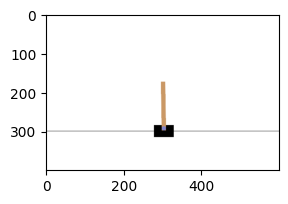

In [8]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1',
                       render_mode='rgb_array',)

        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    # step 就是進行了一次行動
    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()



       

    # #打印游戏图像
    # def show(self):
    #     from matplotlib import pyplot as plt
    #     import numpy as np
    #     img = self.env.render()
    #     print("DEBUG type:", type(img), "shape:", getattr(img, "shape", None))
    #     if not isinstance(img, np.ndarray):
    #         try:
    #             img = np.array(img)
    #             print("DEBUG after np.array, type:", type(img), "shape:", getattr(img, "shape", None))
    #         except Exception as e:
    #             print("ERROR to np.array:", e)
    #             return
    #     print("DEBUG nan count:", np.isnan(img).sum(), "inf count:", np.isinf(img).sum())
    #     plt.figure(figsize=(3, 3))
    #     plt.imshow(img)
    #     plt.axis("off")
    #     plt.show()

    # def show(self):
    #     import numpy as np
    #     from matplotlib import pyplot as plt
    #     from IPython.display import clear_output, display

    #     # 取得 rgb_array
    #     img = self.env.render()

    #     # 保證是 numpy 陣列
    #     if not isinstance(img, np.ndarray):
    #         img = np.array(img)

    #     # 第一次呼叫時建立 fig/ax
    #     if not hasattr(self, '_fig_ax'):
    #         self._fig_ax = plt.subplots(figsize=(3, 3))
    #     fig, ax = self._fig_ax

    #     # 清除上一張、畫新圖
    #     ax.clear()
    #     ax.imshow(img)
    #     ax.axis('off')

    #     # 利用 IPython 介面更新
    #     clear_output(wait=True)
    #     display(fig)

    #     # 暫停一下讓畫面有機會刷新
    #     plt.pause(0.5)


env = MyWrapper()

env.reset()

env.show()

In [9]:
import torch
import torch.nn as nn

# 定義 Q 網路類別
class QNetwork(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# 定義複製模型參數的函數
def clone_model(model):
    clone = QNetwork()  # 這裡假設結構一樣
    clone.load_state_dict(model.state_dict())
    return clone

# 建立主模型
model = QNetwork()
# 用 clone_model 複製出 target 模型
model_delay = clone_model(model)

In [10]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
        if random.random() < 0.1:
            action = env.action_space.sample()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

-993.0

In [11]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

(206,
 (array([ 0.02355098, -0.01158097, -0.02055205,  0.04521785], dtype=float32),
  1,
  1.0,
  array([ 0.02331936,  0.18382956, -0.0196477 , -0.25387794], dtype=float32),
  False))

In [12]:
#训练
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss()

    #共更新N轮数据
    for epoch in range(1000):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #采样N条数据
            state, action, reward, next_state, over = pool.sample()

            #计算value
            value = model(state).gather(dim=1, index=action)

            #计算target
            with torch.no_grad():
                target = model_delay(next_state)
            target = target.max(dim=1)[0].reshape(-1, 1)
            target = target * 0.99 * (1 - over) + reward

            loss = loss_fn(value, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #复制参数
        if (epoch + 1) % 5 == 0:
            model_delay.load_state_dict(model.state_dict())

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), test_result)


train()

0 409 -991.55
100 20000 -426.55
200 20000 99.5
300 20000 200.0
400 20000 200.0
500 20000 200.0
600 20000 200.0
700 20000 200.0
800 20000 200.0
900 20000 -256.6


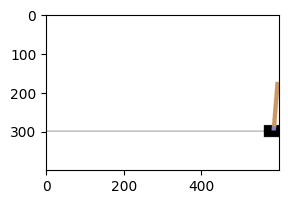

200.0

In [14]:
play(True)[-1]